Starte GridSearchCV... Das kann einige Minuten dauern.


/var/folders/_0/9685wbq50hq47s46lsfcx4x00000gn/T/ipykernel_69891/2402166043.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  apps_df = apps_df[apps_df['Price'].astype(str).str.contains(r'^\$?\d+(\.\d{1,2})?$', na=False)].copy()



Beste Parameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test MSE: 927558126928255.88
Test RMSE: 30455838.96
Test R²: 0.634


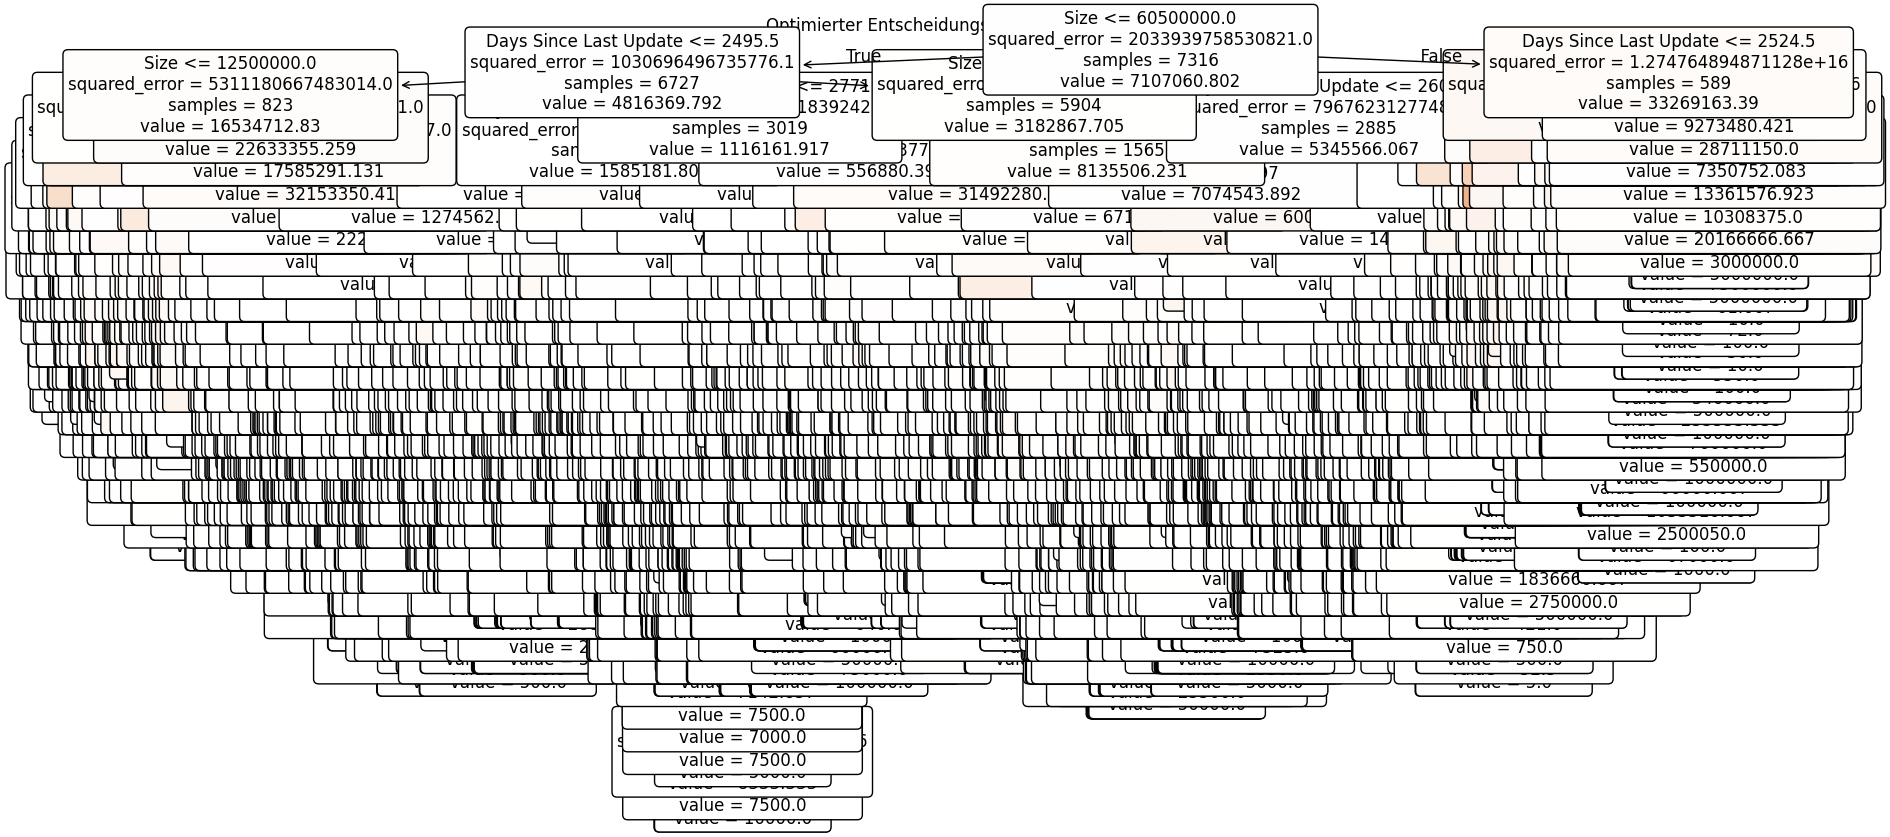

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- 1. Daten einlesen und bereinigen ---
apps_df = pd.read_csv("input/googleplaystore.csv")

# Filter für 'Installs' mit z.B. '1,000,000+'
apps_df = apps_df[apps_df['Installs'].astype(str).str.contains(r'^\d[\d,]*\+$', na=False)].copy()

# Filter für 'Price' mit gültigen Formaten
apps_df = apps_df[apps_df['Price'].astype(str).str.contains(r'^\$?\d+(\.\d{1,2})?$', na=False)].copy()

# 'Installs' bereinigen
apps_df['Installs'] = apps_df['Installs'].str.replace('+', '', regex=False)
apps_df['Installs'] = apps_df['Installs'].str.replace(',', '', regex=False).astype(int)

# 'Price' bereinigen
apps_df['Price'] = apps_df['Price'].str.replace('$', '', regex=False).astype(float)

# 'Reviews' bereinigen (wird später entfernt)
apps_df['Reviews'] = apps_df['Reviews'].astype(str).str.replace(',', '').astype(int)

# 'Size' bereinigen
def parse_size(size):
    if isinstance(size, str):
        if size == 'Varies with device':
            return np.nan
        if 'M' in size:
            return float(size.replace('M', '').replace(',', '').strip()) * 1_000_000
        elif 'k' in size or 'K' in size:
            return float(size.replace('k', '').replace('K', '').replace(',', '').strip()) * 1_000
    return np.nan

apps_df['Size'] = apps_df['Size'].apply(parse_size)
apps_df = apps_df.dropna(subset=['Size']).copy()

# 'Last Updated' in datetime und Days Since Last Update berechnen
apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')
today = pd.to_datetime('today')
apps_df['Days Since Last Update'] = (today - apps_df['Last Updated']).dt.days
apps_df = apps_df.dropna(subset=['Days Since Last Update']).copy()

# Reviews entfernen
apps_df = apps_df.drop(columns=['Reviews'])

# Features & Ziel definieren
features = ['Price', 'Size', 'Category', 'Days Since Last Update']
X = apps_df[features].copy()
y = apps_df['Installs']  # Regression auf Anzahl der Installationen

# Kategorie label-encoden
le = LabelEncoder()
X['Category'] = le.fit_transform(X['Category'])

# Trainings- und Testdaten splitten
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. GridSearchCV für Hyperparameter-Tuning ---
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10]
}

tree = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

print("Starte GridSearchCV... Das kann einige Minuten dauern.")
grid_search.fit(X_train_reg, y_train_reg)

# --- 3. Bestes Modell und Evaluation ---
best_tree = grid_search.best_estimator_
print("\nBeste Parameter:", grid_search.best_params_)

y_pred_best = best_tree.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_best)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

# --- 4. Baum visualisieren ---
plt.figure(figsize=(20,10))
plot_tree(best_tree, feature_names=features, filled=True, rounded=True, fontsize=12)
plt.title("Optimierter Entscheidungsbaum-Regressor")
plt.show()


m